In [1]:
import numpy
import math
from matplotlib import pyplot
%matplotlib inline

In [2]:
#Import the data of airfoil and flap

with open ('../../AeroPython/lessons/resources/NACA23012_MainFoil.csv') as file_name:
    xmain, ymain = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

with open ('../../AeroPython/lessons/resources/NACA23012_FlapFoil.csv') as file_name:
    xflap, yflap = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

In [3]:
class Panel:
    """Contains information related to one panel."""
    def __init__(self, xa, ya, xb, yb):
        """Creates a panel.
        
        Arguments
        ---------
        xa, ya -- Cartesian coordinates of the first end-point.
        xb, yb -- Cartesian coordinates of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'extrados'
        else:
            self.loc = 'intrados'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

In [4]:
def define_panels(x, y, N):
    """Discretizes the geometry into panels using input arrays for the ends of the panels.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the panel endpoints.
    N - number of panels.
    
    Returns
    -------
    panels -- Numpy array of panels.
    """
    x_ends, y_ends = x, y
    panels = numpy.empty(N, dtype=object)
    
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

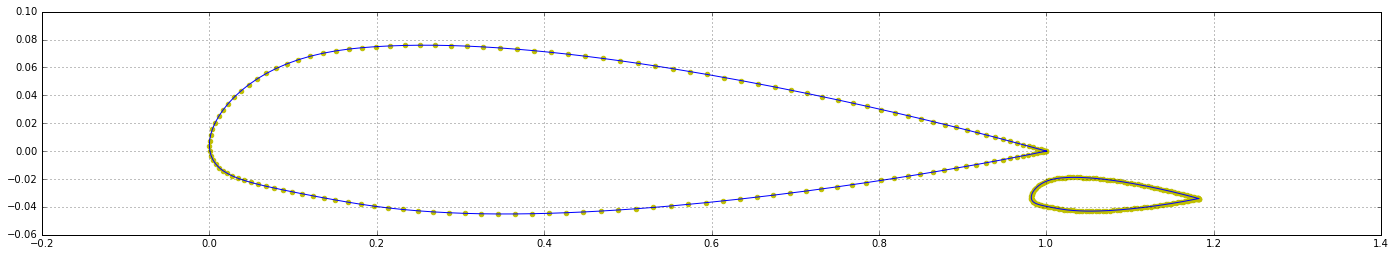

In [7]:
#pyploy the airfoil and flap
N = 150 #set half of N as main airfoil, the other half as flap
pyplot.figure(figsize=(24,4))
pyplot.plot(xmain, ymain, xflap, yflap,  color='b', linestyle='-', linewidth=1);
pyplot.grid(True)
panel_main, panel_flap = define_panels(xmain, ymain, N), define_panels(xflap, yflap, N)
pyplot.scatter([panel.xa for panel in panel_main], [panel.ya for panel in panel_main], color='y');
pyplot.scatter([panel.xa for panel in panel_flap], [panel.ya for panel in panel_flap], color='y');

In [8]:
#difine class for freestream
class Freestream:
    """Freestream conditions."""
    def __init__(self, u_inf, alpha):
        """Sets the freestream conditions.
        
        Parameters
        ----------
        u_inf: float
            Freestream speed; default: 1.0.
        alpha: float
            Angle of attack in degrees; default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [9]:
from scipy import integrate

In [10]:
#Build linear system
def integral(x, y, panel, dxdk, dydk):
    """Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x, y: float
        Coordinates of the point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from panel at point (x, y).
    """
    def func(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(lambda s:func(s), 0., panel.length)[0]

In [11]:
def build_freestream_rhs(panels, freestream):
    """Builds the right hand-side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: Numpy 1d array (Panel object)
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: Numpy 1d array (float)
        Freestream contribution on each panel and on the Kutta condition.
    """
    N = len(panels)
    b = numpy.empty(N+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition on main airfoil
    b[-2] = -freestream.u_inf*( math.sin(freestream.alpha-panels[0].beta)
                              +math.sin(freestream.alpha-panels[(N/2)-1].beta) )
    # freestream contribution on the Kutta condition on flap
    b[-1] = -freestream.u_inf*( math.sin(freestream.alpha-panels[(N/2)].beta)
                              +math.sin(freestream.alpha-panels[N-1].beta) )
    return b

In [12]:
def source_contribution_normal(panels):
    """Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: Numpy 1d array (Panel object)
        List of panels.
    
    Returns
    -------
    A: Numpy 2d array (float)
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [13]:
def vortex_contribution_normal(panels):
    """Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: Numpy 1d array (Panel object)
        List of panels.
    
    Returns
    -------
    A: Numpy 2d array (float)
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [14]:
#build matrix
def build_matrix(panels):
    N = len(panels)
    kutta = numpy.empty((2,N+2), dtype=float)
    At = numpy.zeros((N,N+2), dtype=float)
    main = numpy.zeros((N), dtype=float)
    flap = numpy.zeros((N), dtype=float)
    v = numpy.empty((N,2), dtype=float)
    A = numpy.empty((N+2,N+2), dtype=float)
    
    An = source_contribution_normal(panels)
    Bn = vortex_contribution_normal(panels)
    
    for i, panel_i in enumerate(panels):
        v[i,0] = numpy.sum(Bn[i,:N/2])
        v[i,1] = numpy.sum(Bn[i,N/2:])
    for i, panel_i in enumerate(panels):
        main[i] = numpy.sum(An[i,:N/2])
        flap[i] = numpy.sum(An[i,N/2:])
    
    At[:N,:N] = Bn
    At[:,-2] = -main
    At[:,-1] = -flap
    kutta[0,:] = At[0,:]+At[N/2-1,:]
    kutta[1,:] = At[N/2,:]+At[-1,:]
    A[0:N,0:N], A[0:N,N:], A[N:,:] = An, v, kutta
    
    return A, At

In [15]:
N_main = len(xmain)-1
N_flap = len(xflap)-1

panels_main = define_panels(xmain, ymain, N_main)
panels_flap = define_panels(xflap, yflap, N_flap)
total_panels = numpy.concatenate((panels_main,panels_flap))

In [16]:
def compute_tangential_velocity(panels, freestream, gamma, At):
    """Computes the tangential velocity on the surface.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    gamma -- circulation density.
    """
    N = len(panels)
    
    strength = numpy.append([panel.sigma for panel in panels], gamma)
    
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    vt = numpy.dot(At, strength) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [17]:
def compute_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [19]:
def rotate(xf, yf, rxc, ryc, theta): 
    
    theta = theta * math.pi / 180.
    xf, yf = xf - rxc, yf - ryc
    xf = xf * math.cos(theta) + yf * math.sin(theta)
    yf = -xf * math.sin(theta) + yf * math.cos(theta)
    xf2, yf2 = xf + rxc, yf + ryc
    
    return xf2, yf2

In [25]:
xfnew, yfnew = rotate(xflap, yflap, 1.03, -0.054, 20)

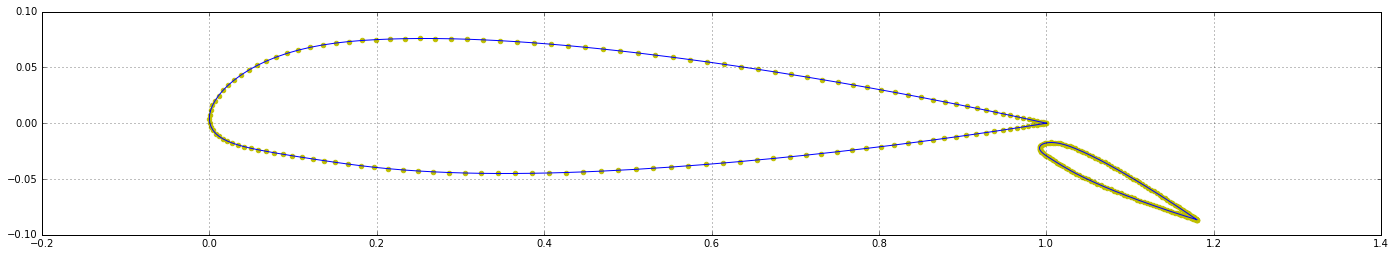

In [27]:
#pyploy the airfoil and flap
N = 150 #set half of N as main airfoil, the other half as flap
pyplot.figure(figsize=(24,4))
pyplot.plot(xmain, ymain, xfnew, yfnew,  color='b', linestyle='-', linewidth=1);
pyplot.grid(True)
panel_main, panel_flap = define_panels(xmain, ymain, N), define_panels(xfnew, yfnew, N)
pyplot.scatter([panel.xa for panel in panel_main], [panel.ya for panel in panel_main], color='y');
pyplot.scatter([panel.xa for panel in panel_flap], [panel.ya for panel in panel_flap], color='y');

In [ ]:
alpha1= -14.
alpha2= 14.
lift = 0
u_inf = 1.
while error<0.0001
    alpha = 0.5*(alpha1+alpha2)
    freestream = Freestream(u_inf,alpha)
    panel_main = define_panels(xmain, ymain, N)
    panel_flap = define_panels(xfnew, yfnew, N)
    panels = numpy.append(panel_main, panel_flap)
    A, At = build_matrix(panels)
    b = build_freestream_rhs(panels,freestream)
    result = numpy.linalg(A, b)
    
    for i